In [1]:
#importing packages
import pandas as pd
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

#importing models
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

## Setup

In [2]:
#reading data
filepath = '~/Documents/DataScience Notebooks/csv/1mio-clean.csv'
df = pd.read_csv(filepath,usecols=[3,5])
df = df.dropna() #removing null-labels
df = df.drop_duplicates()

In [3]:
#mapping to binary classes
df['type_b'] = df['type'].apply(lambda x: 1 if x in ['conspiracy','satire','bias','fake','junksci'] else 0)

In [4]:
#Ratio of FAKE (entire dataset): 
print(f"length: {len(df)}\nratio: {len(df.loc[df['type_b']==1])/len(df)}")

length: 586902
ratio: 0.47641684642410487


In [5]:
#sampling a random subset of 10% size
df_frac = df.sample(frac=0.1)
#ratio of FAKE after sampling
print(f"length: {len(df_frac)}\nratio: {len(df_frac.loc[df_frac['type_b']==1])/len(df_frac)}")

length: 58690
ratio: 0.47612881240415744


## Selecting a baseline
A baseline is selected among 6 default classifiers that are evaluated on 10% of the dataset. The means of cross validation scores are used as scoring metric as this metric is less random than a plain accuracy score, thus giving a stronger foundation for model selection. 

In [6]:
# determine tf-idf 
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_frac['content'])
y = df_frac['type_b']

In [7]:
# models
models = [LinearSVC(),DecisionTreeClassifier(),KNeighborsClassifier(),ComplementNB(),
          LogisticRegression(solver='lbfgs',max_iter=1000),RandomForestClassifier(n_estimators=10)]
# names of models
names = ['LinearSVC','DecisionTreeClassifier','KNeighborsClassifier','ComplementNB',
         'LogisticRegression','RandomForestClassifier']

In [8]:
times = [] #training time (seconds)
means = [] #mean accuracy

for model in models:
    start = time.time()
    scores = cross_val_score(model, X, y, scoring="accuracy", cv=5)
    means.append(scores.mean())
    #model.fit(X_train_frac,y_train_frac)
    #scores.append(model.score(X_test_frac,y_test_frac))
    stop = time.time()
    times.append(stop-start)

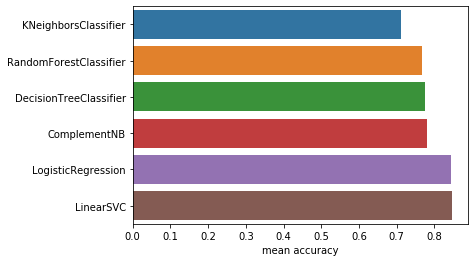

In [9]:
# plot score
d = pd.DataFrame({'name':names, 'mean accuracy':means,'time':times}).sort_values(by=['mean accuracy'])
fig = sns.barplot('mean accuracy','name',data=d)
fig = fig.set_ylabel('')

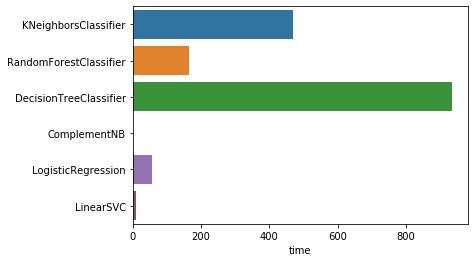

In [10]:
# plot time
fig = sns.barplot('time','name',data=d)
fig = fig.set_ylabel('')

LinearSVC is chosen

## Setup - the entire dataset

In [11]:
#splitting the entire dataset
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['type_b'], test_size=0.2)

In [12]:
# determine tf-idf 
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

## Evaluating LinearSVC baseline 

In [13]:
model = LinearSVC()
model.fit(X_train,y_train)
score = model.score(X_test,y_test)
print(f"accuracy: {score}")

accuracy: 0.8800572494696757


## Evaluating the very simple baseline (the monkey)

In [14]:
#very simple baseline model
def simpleBaseline(X_test,y_train):
    l = X_test.shape[0] #length of test set
    p = round(y_train.mean())
    return [p]*l #returns dense list of all predictions

In [15]:
predVal = simpleBaseline(X_test,y_train)[0]
#Accuracy of simple baseline
simpleAcc = list(y_test).count(predVal)/len(y_test)
print(f"accuracy: {simpleAcc}")

accuracy: 0.5250253448173043
